In [1]:
# for files
import os
from google_drive_downloader import GoogleDriveDownloader as gdd
# for data processing
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
if not os.path.exists('./data'):
  os.mkdir('./data')

gdd.download_file_from_google_drive(file_id='1xk2VMXJiUNmxDPbf67lebr0fD54eeT8d', dest_path='./data/demodata.zip')

In [3]:
! unzip ./data/demodata.zip -d ./data

Archive:  ./data/demodata.zip
   creating: ./data/demodata/
  inflating: ./data/demodata/transactions.csv  
  inflating: ./data/demodata/prices.csv  


## Transaction dataframe

In [4]:
trans = pd.read_csv('/content/data/demodata/transactions.csv')

No nulls

In [5]:
trans.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23672436 entries, 0 to 23672435
Data columns (total 7 columns):
 #   Column      Non-Null Count     Dtype 
---  ------      --------------     ----- 
 0   Unnamed: 0  23672436 non-null  int64 
 1   item_id     23672436 non-null  object
 2   cat_id      23672436 non-null  object
 3   store_id    23672436 non-null  object
 4   quantity    23672436 non-null  int64 
 5   date        23672436 non-null  object
 6   wm_yr_wk    23672436 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.2+ GB


We have days with 0 quantity

In [6]:
trans.head()

,Unnamed: 0,item_id,cat_id,store_id,quantity,date,wm_yr_wk
0,0,HOBBIES_1_001,HOBBIES,CA_1,0,2011-01-29,11101
1,1,HOBBIES_1_002,HOBBIES,CA_1,0,2011-01-29,11101
2,2,HOBBIES_1_003,HOBBIES,CA_1,0,2011-01-29,11101
3,3,HOBBIES_1_004,HOBBIES,CA_1,0,2011-01-29,11101
4,4,HOBBIES_1_005,HOBBIES,CA_1,0,2011-01-29,11101


In [7]:
trans.drop(columns={'Unnamed: 0'},inplace=True)

In [8]:
trans['date'] = pd.to_datetime(trans['date'])

1941 observation for each item,store pair

In [9]:
trans.groupby(['item_id', 'store_id']).agg(values_per_item=('quantity','count')).describe()

,values_per_item
count,12196.0
mean,1941.0
std,0.0
min,1941.0
25%,1941.0
50%,1941.0
75%,1941.0
max,1941.0


In [10]:
print('Unique items {i}, unique stores {s}, unique categories {c}'.format(i=trans['item_id'].nunique(), s=trans['store_id'].nunique(), c=trans['cat_id'].nunique()))

Unique items 3049, unique stores 4, unique categories 3


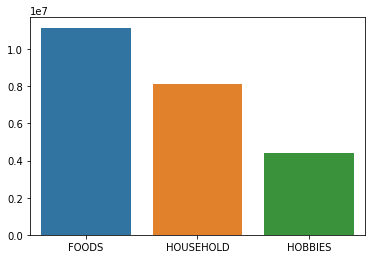

In [11]:
tmp=trans['cat_id'].value_counts()
sns.barplot(list(tmp.index), tmp.values)

In [13]:
rand_indices = np.random.randint(0,trans['item_id'].nunique(),size=5)
random_items = np.array(trans['item_id'].unique())[rand_indices]

Daily quantity

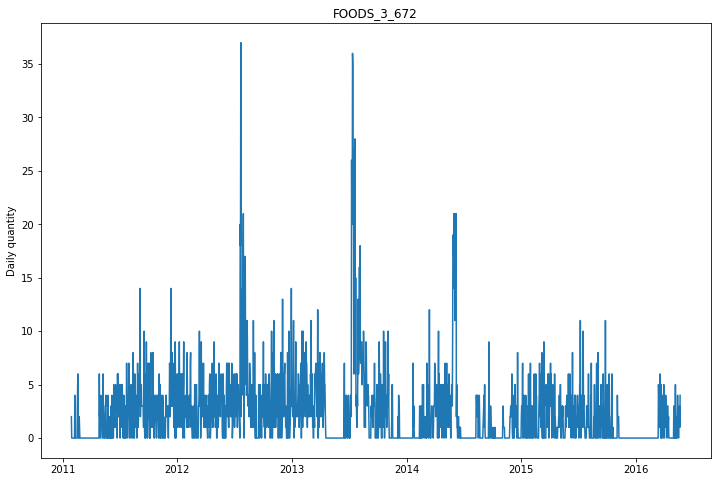

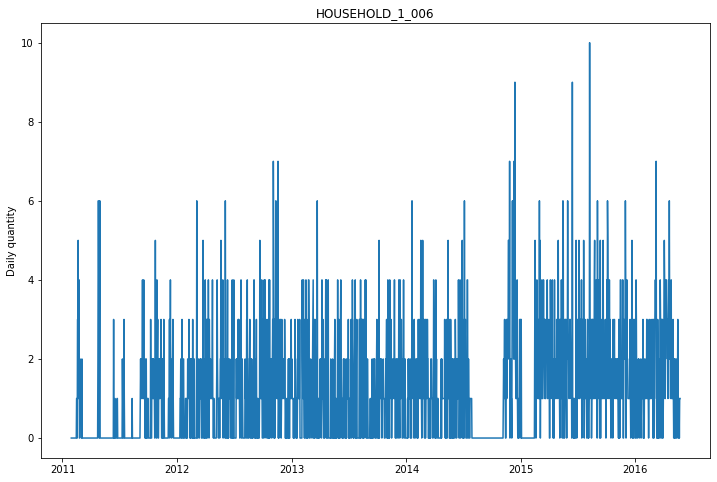

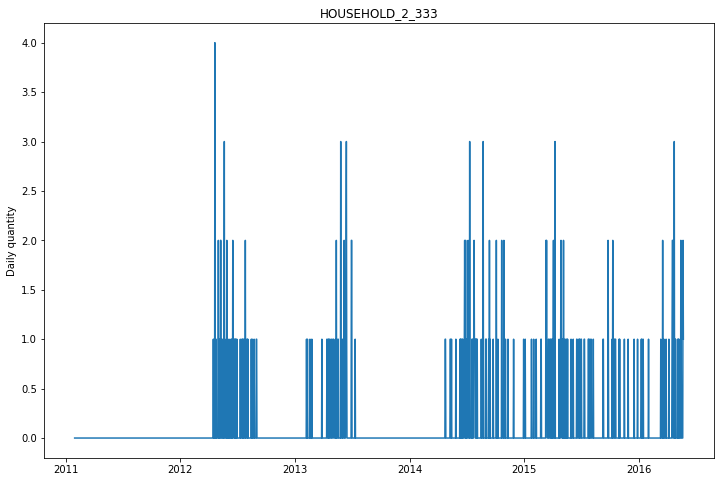

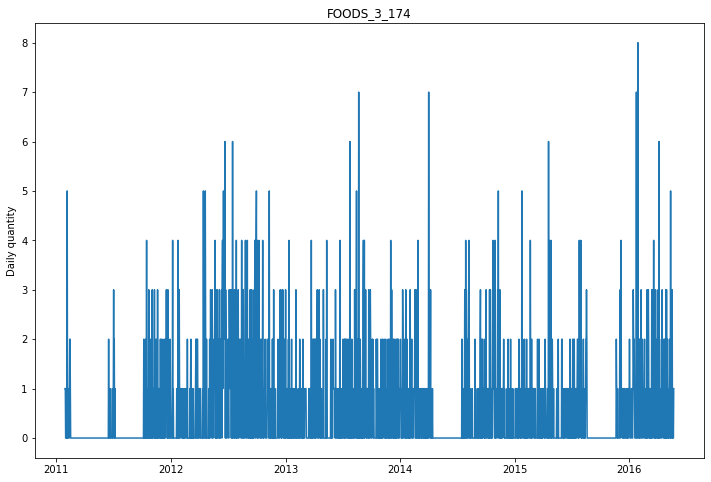

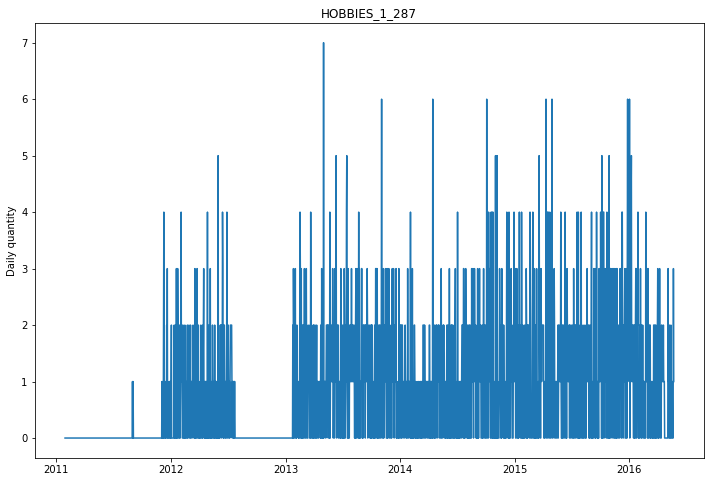

In [14]:
for item_id in random_items:
  tmp = trans.query('item_id == @item_id and store_id == "CA_1"')
  tmp.sort_values(by='date')
  plt.figure(figsize=(12,8))
  plt.plot(tmp['date'], tmp['quantity'])
  plt.title(item_id)
  plt.ylabel('Daily quantity')
  plt.show()

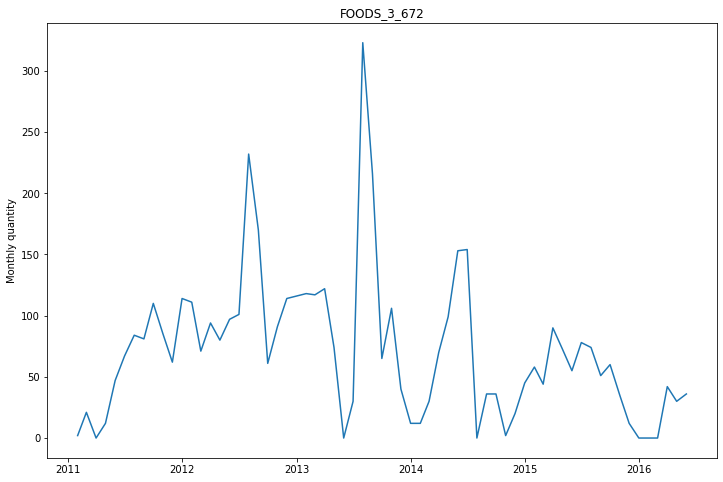

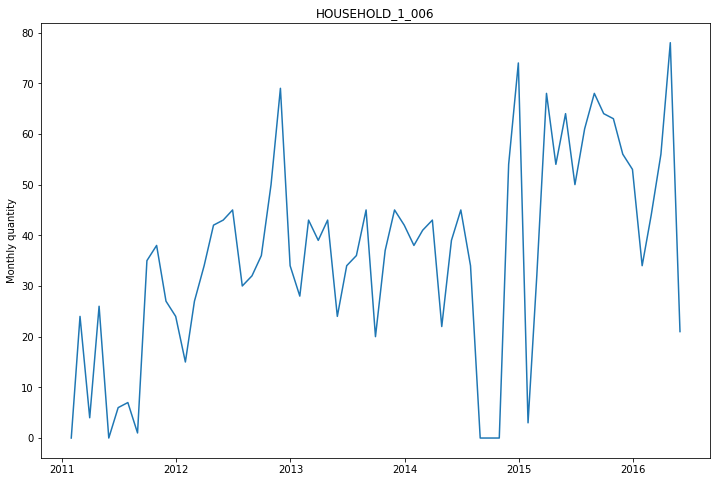

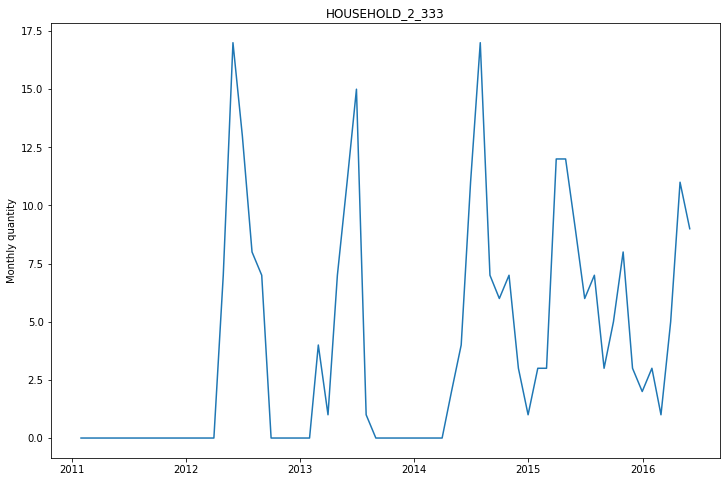

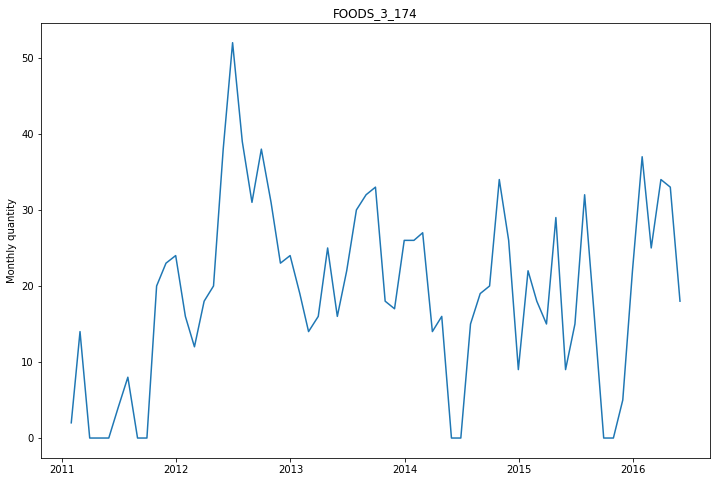

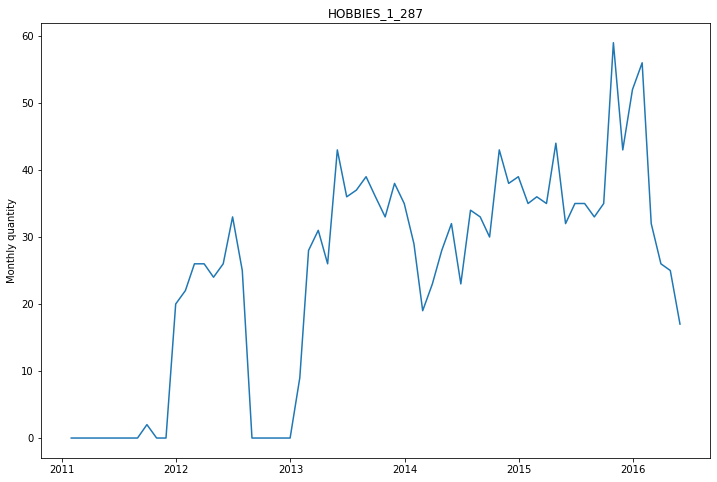

In [15]:
for item_id in random_items:
  tmp = trans.query('item_id == @item_id and store_id == "CA_1"')
  tmp.sort_values(by='date')
  tmp.set_index('date',inplace=True)
  monthly_agg = tmp.resample('1M').agg({'quantity':'sum'})
  plt.figure(figsize=(12,8))
  plt.plot(monthly_agg.index, monthly_agg['quantity'])
  plt.title(item_id)
  plt.ylabel('Monthly quantity')
  plt.show()

## Price dataframe


In [16]:
prices = pd.read_csv('/content/data/demodata/prices.csv')

In [17]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  6841121 non-null  int64  
 1   store_id    6841121 non-null  object 
 2   item_id     6841121 non-null  object 
 3   wm_yr_wk    6841121 non-null  int64  
 4   sell_price  6841121 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 261.0+ MB


In [18]:
prices.head()

,Unnamed: 0,store_id,item_id,wm_yr_wk,sell_price
0,0,CA_1,HOBBIES_1_001,11325,9.58
1,1,CA_1,HOBBIES_1_001,11326,9.58
2,2,CA_1,HOBBIES_1_001,11327,8.26
3,3,CA_1,HOBBIES_1_001,11328,8.26
4,4,CA_1,HOBBIES_1_001,11329,8.26


In [19]:
prices.drop(columns=['Unnamed: 0'],inplace=True)

Let's join with transactions

In [20]:
trans.shape

(23672436, 6)

In [22]:
joined_df = pd.merge(trans, prices, on=['item_id','store_id','wm_yr_wk'], how='left')

In [23]:
joined_df.shape

(23672436, 7)

If we have 0 quantity (no transaction this day), we don't know sell_price

In [24]:
joined_df

,item_id,cat_id,store_id,quantity,date,wm_yr_wk,sell_price
0,HOBBIES_1_001,HOBBIES,CA_1,0,2011-01-29,11101,NaN
1,HOBBIES_1_002,HOBBIES,CA_1,0,2011-01-29,11101,NaN
2,HOBBIES_1_003,HOBBIES,CA_1,0,2011-01-29,11101,NaN
3,HOBBIES_1_004,HOBBIES,CA_1,0,2011-01-29,11101,NaN
4,HOBBIES_1_005,HOBBIES,CA_1,0,2011-01-29,11101,NaN
...,...,...,...,...,...,...,...
23672431,FOODS_3_823,FOODS,CA_4,0,2016-05-22,11617,2.98
23672432,FOODS_3_824,FOODS,CA_4,0,2016-05-22,11617,2.48
23672433,FOODS_3_825,FOODS,CA_4,0,2016-05-22,11617,3.98
23672434,FOODS_3_826,FOODS,CA_4,4,2016-05-22,11617,1.28


Daily price

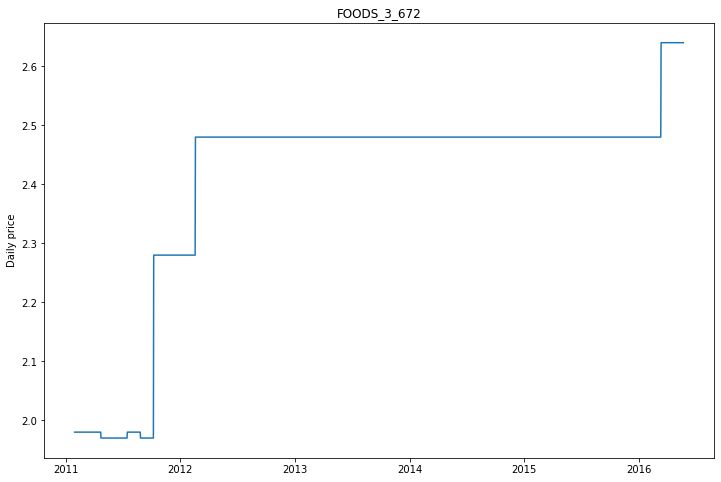

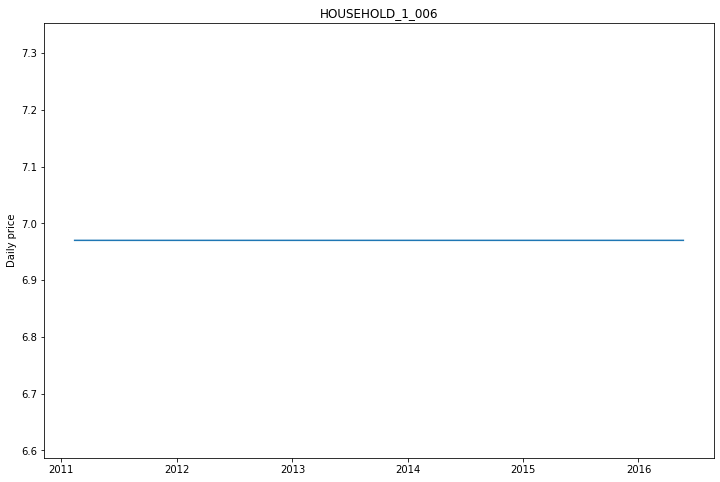

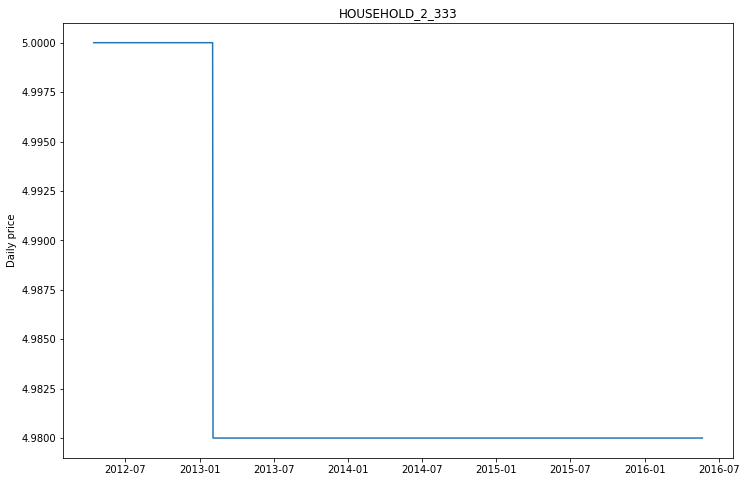

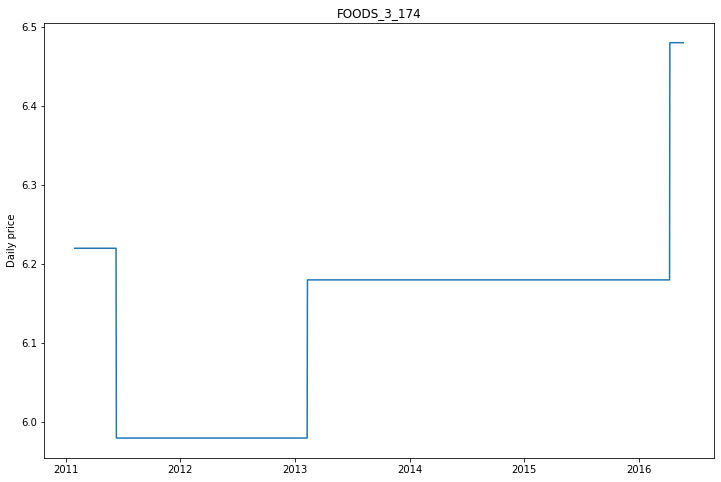

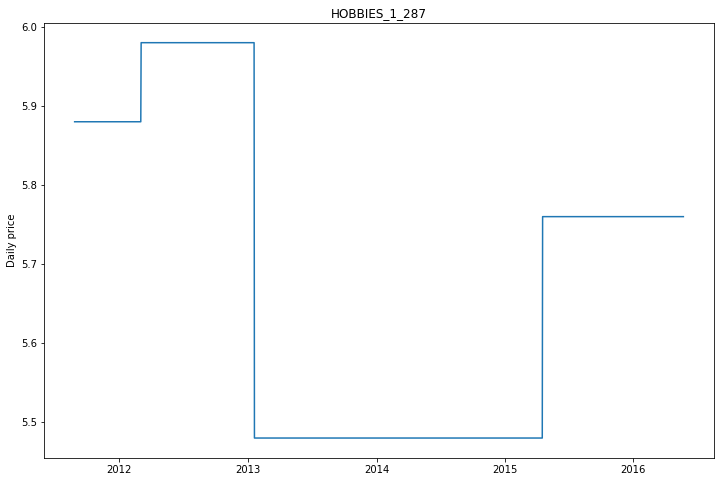

In [25]:
for item_id in random_items:
  tmp = joined_df.query('item_id == @item_id and store_id == "CA_1"')
  tmp.sort_values(by='date')
  plt.figure(figsize=(12,8))
  plt.plot(tmp['date'], tmp['sell_price'])
  plt.title(item_id)
  plt.ylabel('Daily price')
  plt.show()

Monthly price

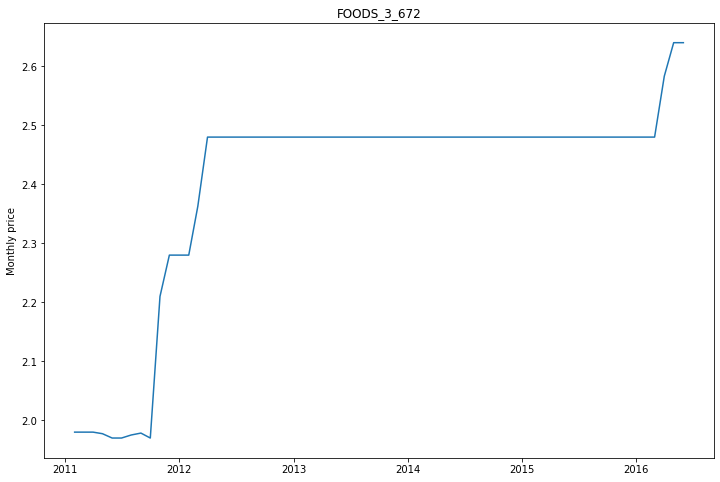

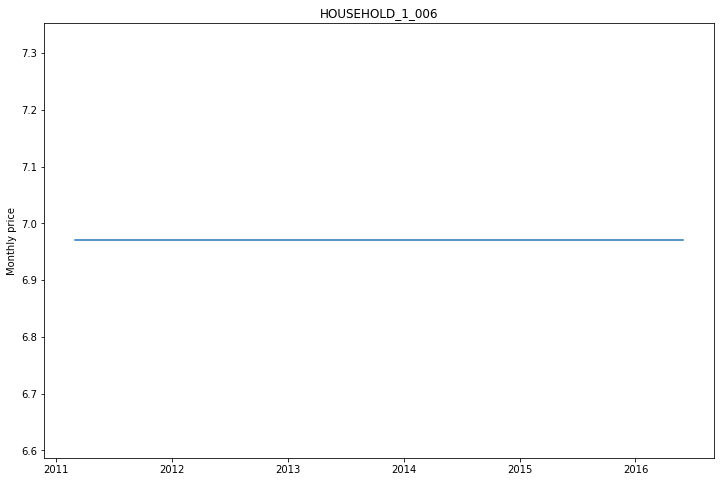

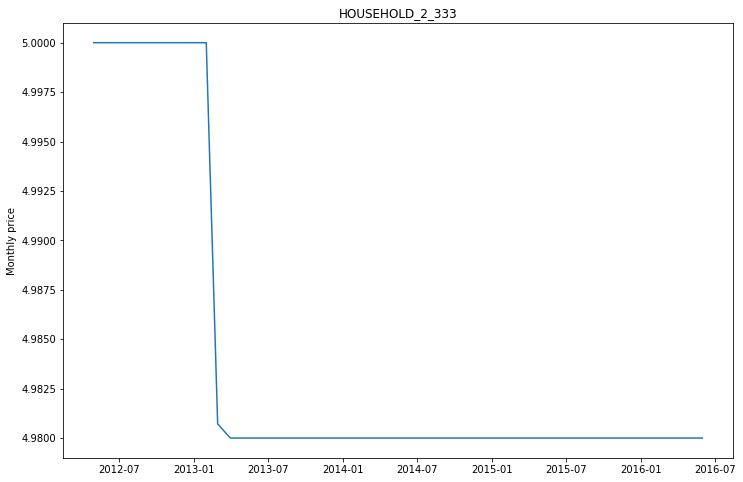

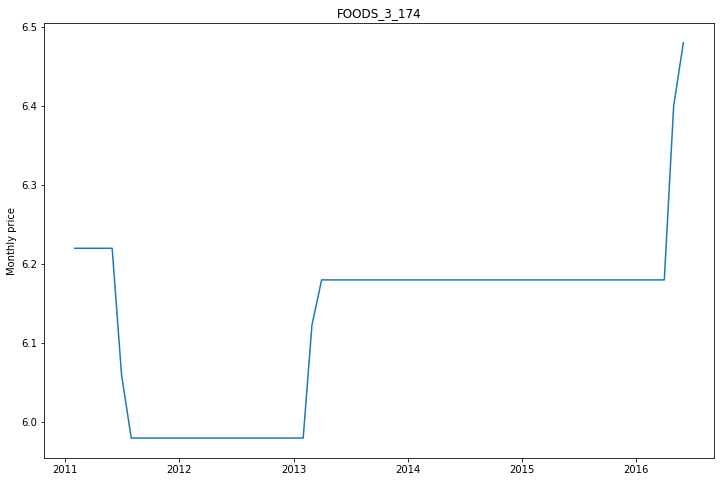

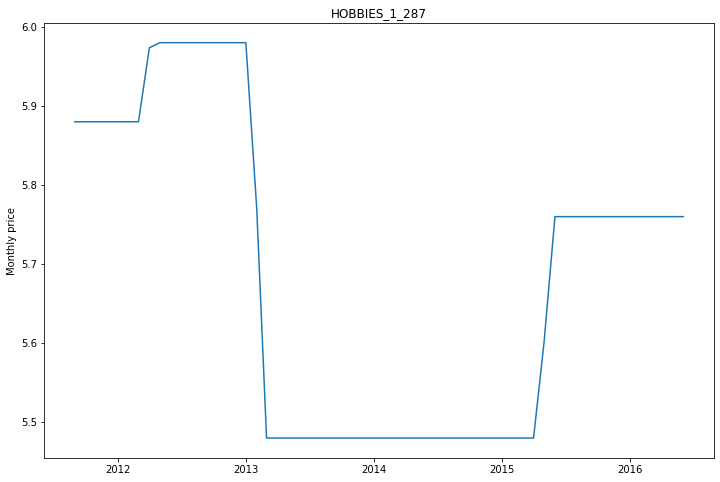

In [26]:
for item_id in random_items:
  tmp = joined_df.query('item_id == @item_id and store_id == "CA_1"')
  tmp.sort_values(by='date')
  tmp.set_index('date',inplace=True)
  monthly_agg = tmp.resample('1M').agg({'sell_price':'mean'})
  plt.figure(figsize=(12,8))
  plt.plot(monthly_agg.index, monthly_agg['sell_price'])
  plt.title(item_id)
  plt.ylabel('Monthly price')
  plt.show()

Price is more or less stable in general